Let's start by creating an instance of the droneMPC class. Initializing in hover and r=l0. Set a reference and call the solve method to see if everything runs through.

In [1]:
from drone_MPC import DroneMPC, DroneMPCOptions
import numpy as np

# Define an initial state corresponding to hovering.
# For the full model, the state is:
# [y, z, phi, r, theta, y_dot, z_dot, phi_dot, r_dot, theta_dot, w1, w2]
# where:
#   - y = 0.0 (horizontal position), z = 1.0 (altitude)
#   - phi (drone pitch) = 0.0, theta (pendulum angle) = 0.0
#   - r is set to the spring rest length (l0)
#   - All velocities are 0.
#   - Rotor speeds (w1, w2) are chosen such that the total thrust equals the weight.
l0 = 0.3
M = 2.0
m = 0.1
M_total = M + m
c = 1
g = 9.81
# Required total thrust for hovering T = (M_total)*g, and assuming symmetric rotors, each rotor speed is set to T/2 (with c=1)
w_val = (M_total * g) / (2.0*c)

# Create an instance of the MPC options (using the updated physical parameters)
opts = DroneMPCOptions(
    M=M,         # drone mass in kg
    m=m,         # load mass in kg (small compared to drone)
    Ixx=0.05,      # moment of inertia in kg·m²
    g=g,        # gravitational acceleration in m/s²
    c=c,         # rotor thrust constant
    L_rot=0.2,     # half distance between rotors in m
    k=400.0,       # stiff spring (N/m)
    l0=l0,        # spring rest length in m
    # Constraints and cost weighting matrices remain as defined by default

    N = 300,
    switch_stage = 150,
    step_sizes = [0.005]*300,

    w_min = -2*w_val,
    w_max = 2*w_val,
    w_dot_min = -30,
    w_dot_max = 30,
    phi_min = -np.pi*3/10,
    phi_max = np.pi*3/10,
    F_min = -2*w_val*c,
    F_max = 2*w_val*c,

    integrator_type="IRK"
)

# Create an instance of the DroneMPC class
mpc = DroneMPC(opts)

x0 = np.array([
    0.0,    # y position
    1.0,    # z position (hover altitude)
    0.0,    # phi (drone pitch)
    l0,     # r (pendulum length set to rest length)
    0.0,    # theta (pendulum angle)
    0.0,    # y_dot
    0.0,    # z_dot
    0.0,    # phi_dot
    0.0,    # r_dot
    0.0,    # theta_dot
    w_val,  # w1 (rotor speed)
    w_val   # w2 (rotor speed)
])
print("Initial hovering state:", x0)

# Define a reference position far away (for example, [10, 10])
pos_ref = np.array([5.0, 2.0])

# set initial guess to avoid division by zero for r
mpc.set_initial_guess(x0, u_guess=np.zeros(2))

# Call the MPC solve function to compute the first control input
u0 = mpc.solve(x0, pos_ref)
print("First control input:", u0)

The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globaliza

acados_solver_multiphase_ocp_150_1_150_20250325_205049_366128.c: In function ‘multiphase_ocp_150_1_150_20250325_205049_366128_acados_create_with_discretization’:
acados_solver_multiphase_ocp_150_1_150_20250325_205049_366128.c:2833:25: warning: too many arguments for format [-Wformat-extra-args]
 2833 |         fprintf(stderr, "multiphase_ocp_150_1_150_20250325_205049_366128_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o drone_full_1742961049366_model/drone_full_1742961049366_impl_dae_fun.o drone_full_1742961049366_model/drone_full_1742961049366_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o drone_full_1742961049366_model/drone_full_1742961049366_impl_dae_fun_jac_x_xdot_z.o drone_full_17429610493

Next, let's visualize the the openloop plan and check whether it makes sense what the MPCs compute.

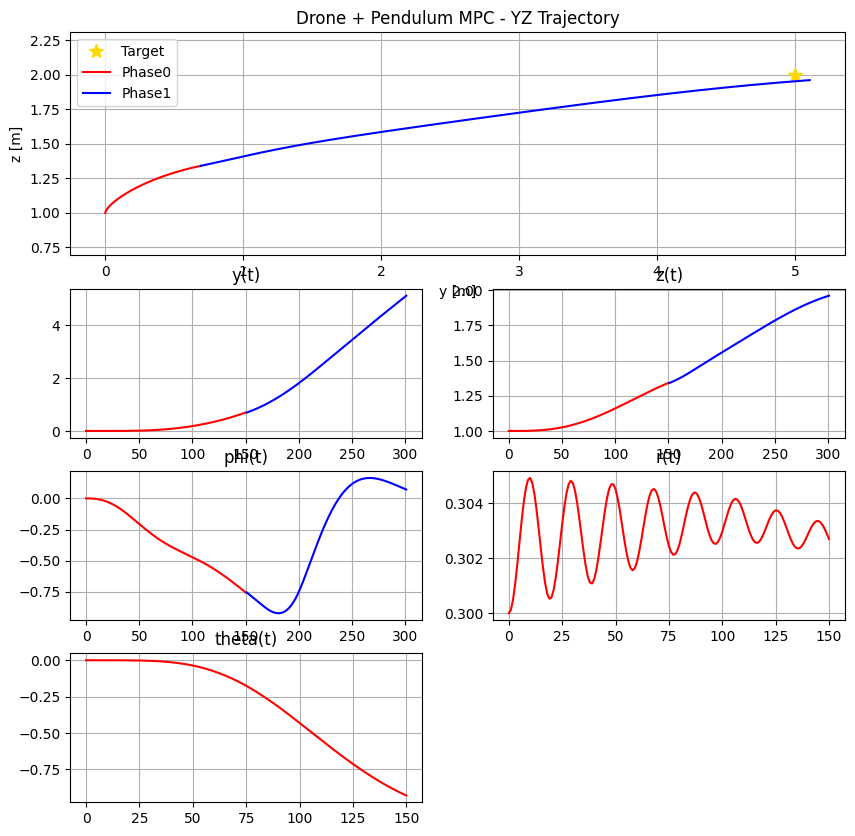

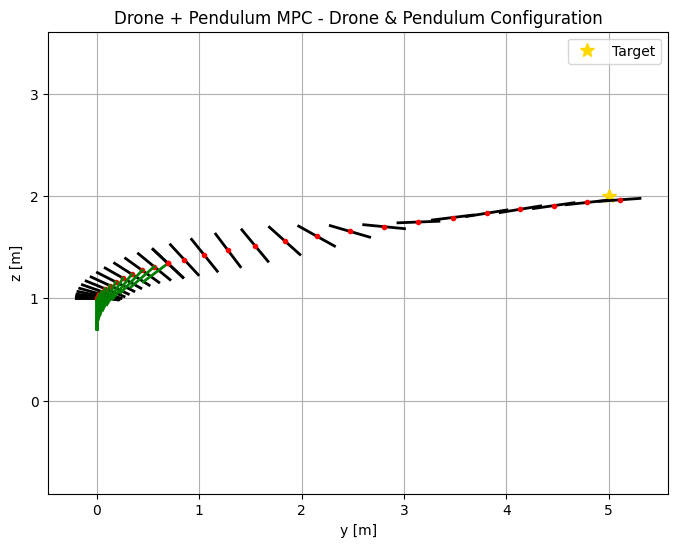

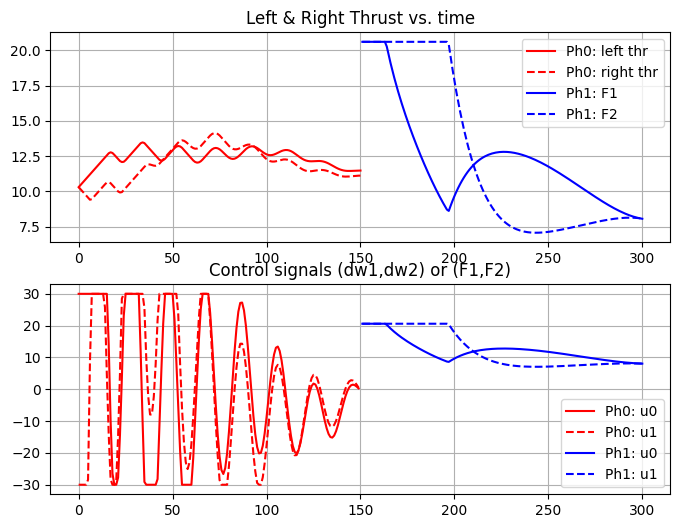

In [2]:
from plotting_utils_drone import plot_drone_mpc_solution

x_traj, u_traj = mpc.get_planned_trajectory()

plot_drone_mpc_solution(
    mpc=mpc, 
    reference_xy=pos_ref,
    open_loop_plan=x_traj,
    u_traj=u_traj,
    step_pose=10
)

Next, let's simulate in closed loop and see if the taken trajectories are sensible.

In [3]:
# from utils_drone import simulate_closed_loop_drone
# from copy import deepcopy

# # create a full mpc to obtain the cost function
# mpc_full_opts = deepcopy(opts)
# mpc_full_opts.N = 1
# mpc_full_opts.switch_stage = 1
# mpc_full_opts.step_sizes = [opts.step_sizes[0]]*1
# mpc_full = DroneMPC(mpc_full_opts)

# duration = 4

# x_traj, u_traj, costs, solve_times = simulate_closed_loop_drone(
#     x0, 
#     mpc, 
#     duration, 
#     target_xy=pos_ref,
#     stage_cost_function=mpc_full.stage_cost_func_full,
#     sigma_noise=0.0,  
#     sim_solver=None, 
#     control_step=1
# )

# plot_drone_mpc_solution(
#     mpc=mpc, 
#     reference_xy=pos_ref,
#     closed_loop_traj=x_traj,
#     u_traj=u_traj,
#     step_pose=10
# )

# print(np.mean(costs))
# print(np.mean(solve_times))

Last step before the experiment. Try if it works when simulating with a zero order hold, treating a model integrated with smaller step sizes as ground truth.

In [4]:
# from copy import deepcopy
# from utils_drone import simulate_closed_loop_drone
# import gc
# import shutil

# ### 0) Baseline ###
# dt_sim = 0.0025 # model with IRK and this stepsize is treated as ground truth here
# mpc_opts_sim = deepcopy(opts)
# mpc_opts_sim.N = 1
# mpc_opts_sim.step_sizes = [dt_sim]*1
# mpc_opts_sim.switch_stage = 2
# mpc_opts_sim.integrator_type = "IRK"
# mpc_sim = DroneMPC(mpc_opts_sim)
# sim_solver = mpc_sim.sim_solver_full

# del mpc_sim
# gc.collect()
# shutil.rmtree('c_generated_code', ignore_errors=True)

# duration = 5

# # set initial guess to avoid division by zero for r
# mpc.set_initial_guess(x0, u_guess=np.zeros(2))

# x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
#     x0, 
#     mpc, 
#     duration, 
#     target_xy=pos_ref,
#     stage_cost_function=mpc_sim.stage_cost_func_full,
#     sigma_noise=0.0,  
#     sim_solver=sim_solver, 
#     control_step=2
# )

# plot_drone_mpc_solution(
#     mpc=mpc, 
#     reference_xy=pos_ref,
#     closed_loop_traj=x_traj,
#     u_traj=u_traj,
#     step_pose=10
# )

# print(np.mean(stage_costs))
# print(np.mean(solve_times))

Ok, finally we run a comparison of approaches. We treat the model integrated with IRK and a step size of 0.0025 (500 HZ) as ground truth. To show what we have observed, we run:

0) Baseline MPC: Exact model, long horizon and small step sizes, integrated with IRK. We use a levenberg-marquardt regularization of the Hessian of 8e-3 (tuned for appropriate convergence). Levenberg-marquardt can slow doen convergence, but helps with problems due to ill-conditioning.

1) Same as 0), but integrated with ERK. Tests if IRK is necessary for this slow-fast system. This shows that .

2) Same as 0), but with a levenberg-marquardt regularization of 1e-3 (What we use for the multi-phase case and the approximate model only case). This shows that with a lower value for the regularization parameter, the ill-conditioning leads to solver failures (exit status 3 of QP -> NaN Evaluations detected).

3) Exact model case, but with larger step sizes (and applied at a higher frequency). Same time horizon as 0)

4) Myopic MPC, Same as 0), but with horizon of 100.

5) Approximate model only, ignore pendulum model. Despite that, as 0)

6) Exact model with exponential increase of step sizes at a sensible rate. Same time lookahead as 0)

7) Model switching without step size increase, step sizes and horizon as 0)

8) Our approach: Combines model switching with an exponential increase of step size


In [5]:
from copy import deepcopy
from utils_drone import simulate_closed_loop_drone
import gc
import shutil

### Setup ###
dt_sim = 0.0025 # model with IRK and this stepsize is treated as ground truth here
mpc_opts_sim = deepcopy(opts)
mpc_opts_sim.N = 1
mpc_opts_sim.step_sizes = [dt_sim]*1
mpc_opts_sim.switch_stage = 2
mpc_opts_sim.integrator_type = "IRK"
mpc_sim = DroneMPC(mpc_opts_sim)
sim_solver = mpc_sim.sim_solver_full

del mpc_sim
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

# collect mean costs and solve times
mean_costs = []
mean_solve_times = []

# MPC config shared by all MPCs 
dt_inital_mpc = 0.005
control_step = int(dt_inital_mpc/dt_sim) # determines zero order hold of the MPC
X0 = np.array([0.0, 1.0, 0.0, l0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, w_val, w_val])
duration = 0.2

rm -f libacados_ocp_solver_drone_full_1742961066864.so
rm -f drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_0_fun.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_0_fun_jac_ut_xt.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_0_hess.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_fun.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_fun_jac_ut_xt.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_hess.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_e_fun.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_e_fun_jac_ut_xt.o drone_full_1742961066864_cost/drone_full_1742961066864_cost_y_e_hess.o acados_solver_drone_full_1742961066864.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

rm -f libacados_ocp_solver_drone_full_1742961075165.so
rm -f drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_0_fun.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_0_fun_jac_ut_xt.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_0_hess.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_fun.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_fun_jac_ut_xt.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_hess.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_e_fun.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_e_fun_jac_ut_xt.o drone_full_1742961075165_cost/drone_full_1742961075165_cost_y_e_hess.o acados_solver_drone_full_1742961075165.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

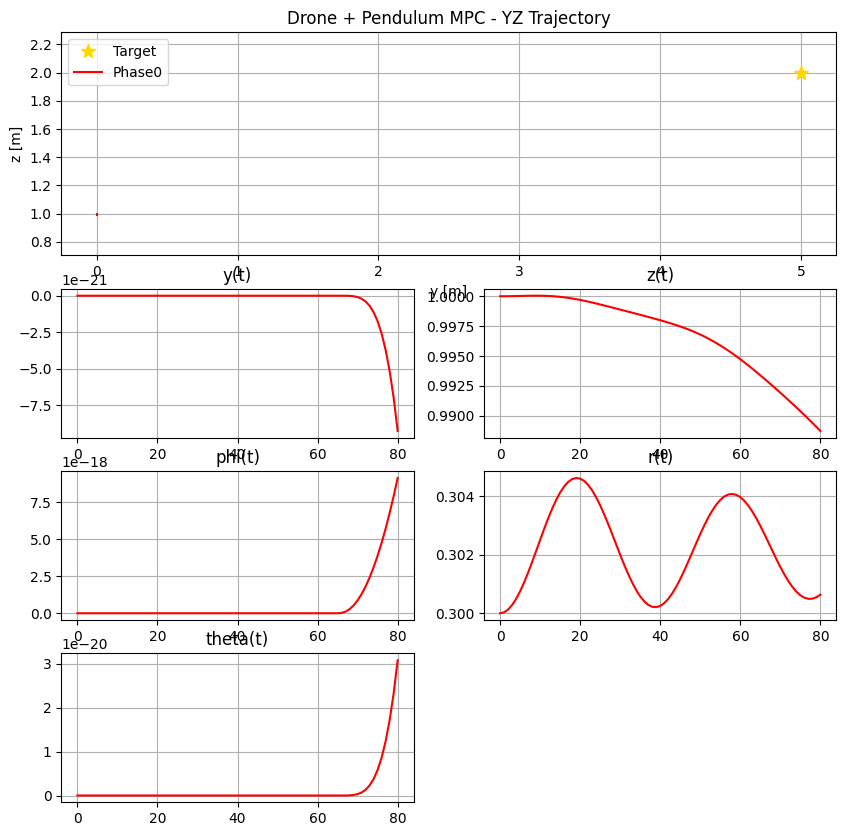

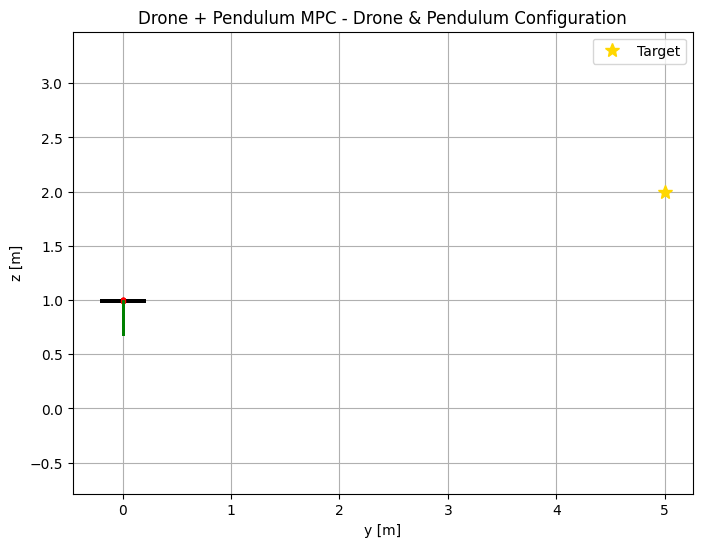

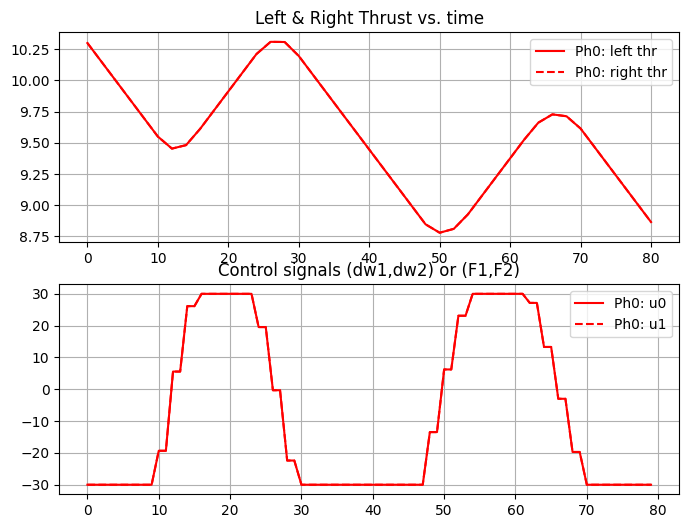

In [6]:
### 0) Baseline MPC ###
mpc_opts_baseline = deepcopy(opts)
N = 300
mpc_opts_baseline.N = N
mpc_opts_baseline.step_sizes = [dt_inital_mpc]*N
mpc_opts_baseline.switch_stage = N+1
mpc_opts_baseline.integrator_type = "IRK"
mpc_opts_baseline.levenberg_marquardt = 8e-3
mpc_baseline = DroneMPC(mpc_opts_baseline)

stage_cost_function=mpc_baseline.stage_cost_func_full # save stage costs function

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_baseline, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_baseline, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_baseline
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

rm -f libacados_ocp_solver_drone_full_1742961119767.so
rm -f drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_0_fun.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_0_fun_jac_ut_xt.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_0_hess.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_fun.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_fun_jac_ut_xt.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_hess.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_e_fun.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_e_fun_jac_ut_xt.o drone_full_1742961119767_cost/drone_full_1742961119767_cost_y_e_hess.o acados_solver_drone_full_1742961119767.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

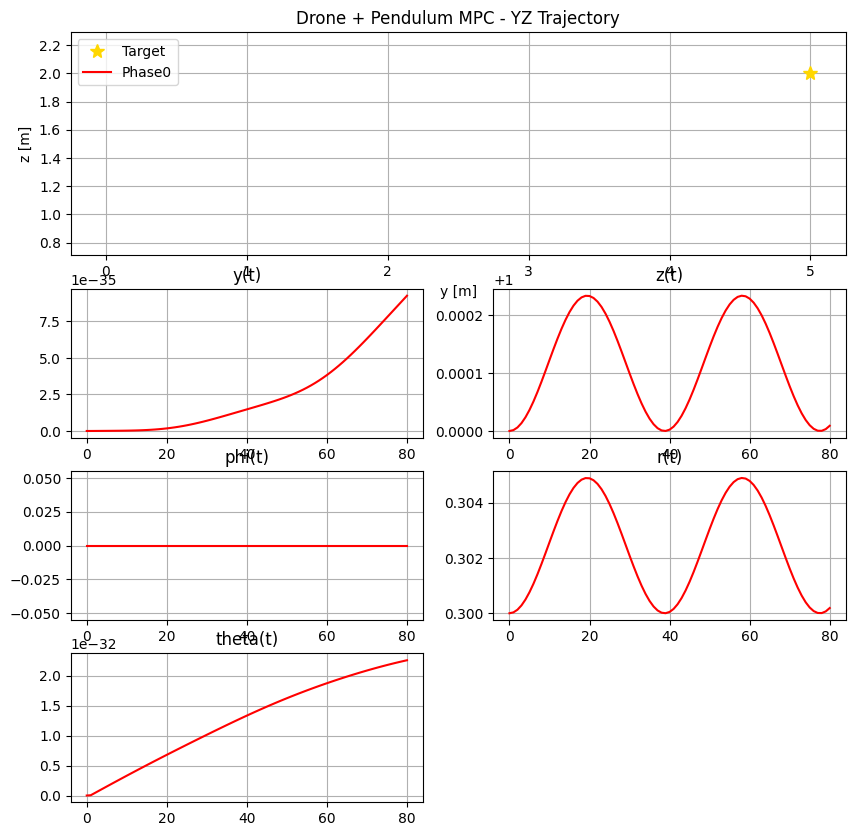

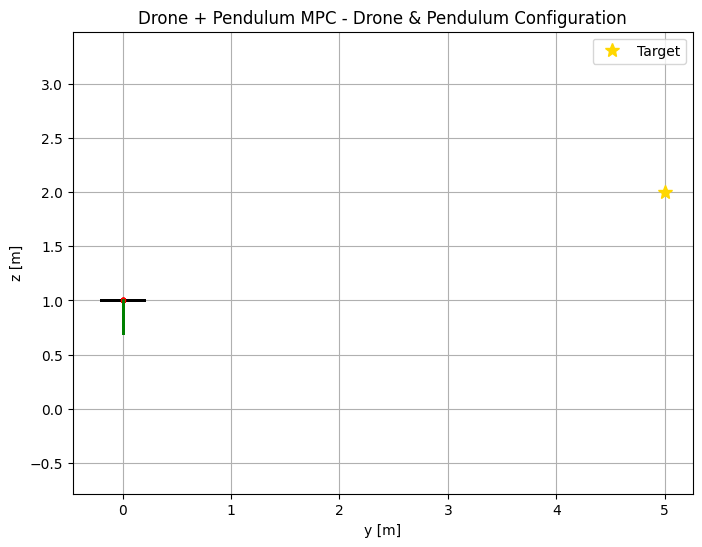

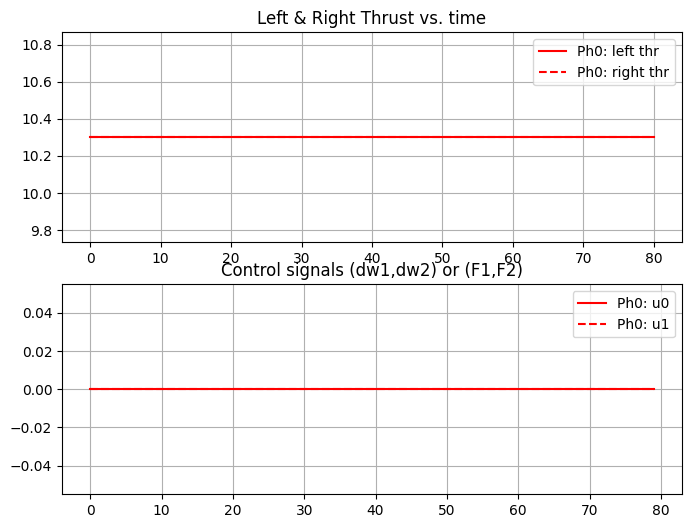

In [7]:
### 1) Baseline MPC with ERK ###
mpc_opts_1 = deepcopy(opts)
N = 300
mpc_opts_1.N = N
mpc_opts_1.step_sizes = [dt_inital_mpc]*N
mpc_opts_1.switch_stage = N+1
mpc_opts_1.integrator_type = "ERK"
mpc_opts_1.levenberg_marquardt = 8e-3
mpc_1 = DroneMPC(mpc_opts_1)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_1, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_1, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_1
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

rm -f libacados_ocp_solver_drone_full_1742961129534.so
rm -f drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_0_fun.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_0_fun_jac_ut_xt.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_0_hess.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_fun.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_fun_jac_ut_xt.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_hess.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_e_fun.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_e_fun_jac_ut_xt.o drone_full_1742961129534_cost/drone_full_1742961129534_cost_y_e_hess.o acados_solver_drone_full_1742961129534.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

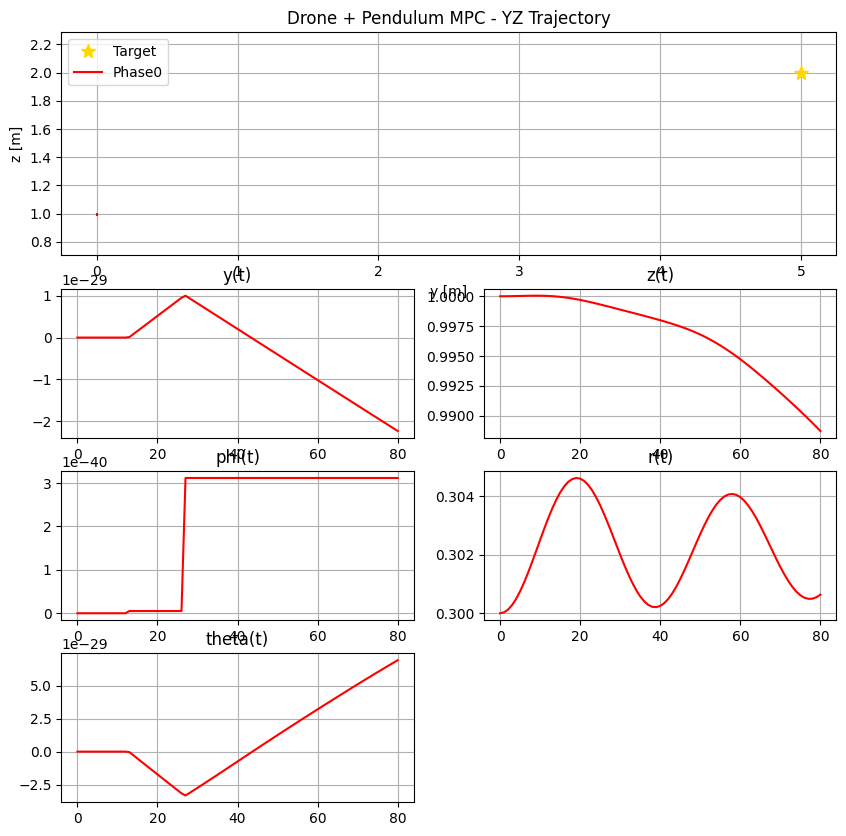

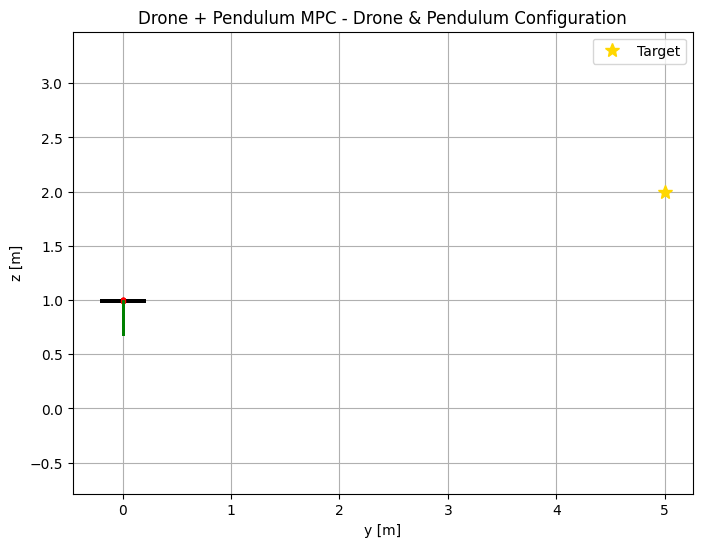

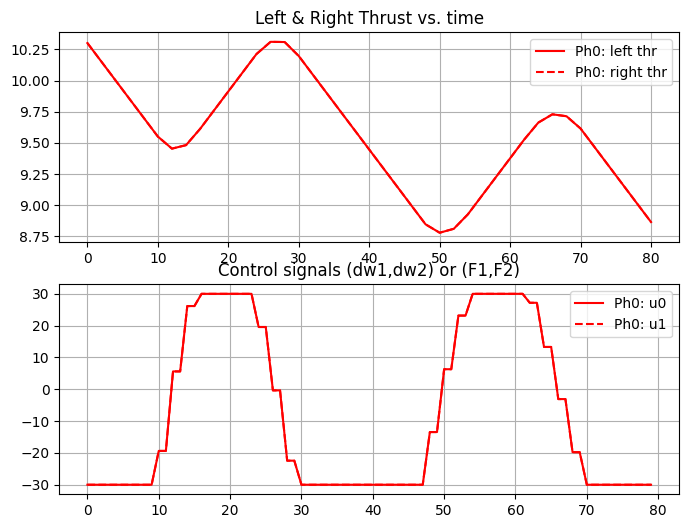

In [8]:
### 2) Baseline with smaller value for levenberg-marquardt ###
mpc_opts_2 = deepcopy(opts)
N = 300
mpc_opts_2.N = N
mpc_opts_2.step_sizes = [dt_inital_mpc]*N
mpc_opts_2.switch_stage = N+1
mpc_opts_2.integrator_type = "IRK"
mpc_opts_2.levenberg_marquardt = 1e-3
mpc_2 = DroneMPC(mpc_opts_2)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_2, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_2, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_2
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

rm -f libacados_ocp_solver_drone_full_1742961145807.so
rm -f drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_0_fun.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_0_fun_jac_ut_xt.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_0_hess.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_fun.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_fun_jac_ut_xt.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_hess.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_e_fun.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_e_fun_jac_ut_xt.o drone_full_1742961145807_cost/drone_full_1742961145807_cost_y_e_hess.o acados_solver_drone_full_1742961145807.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

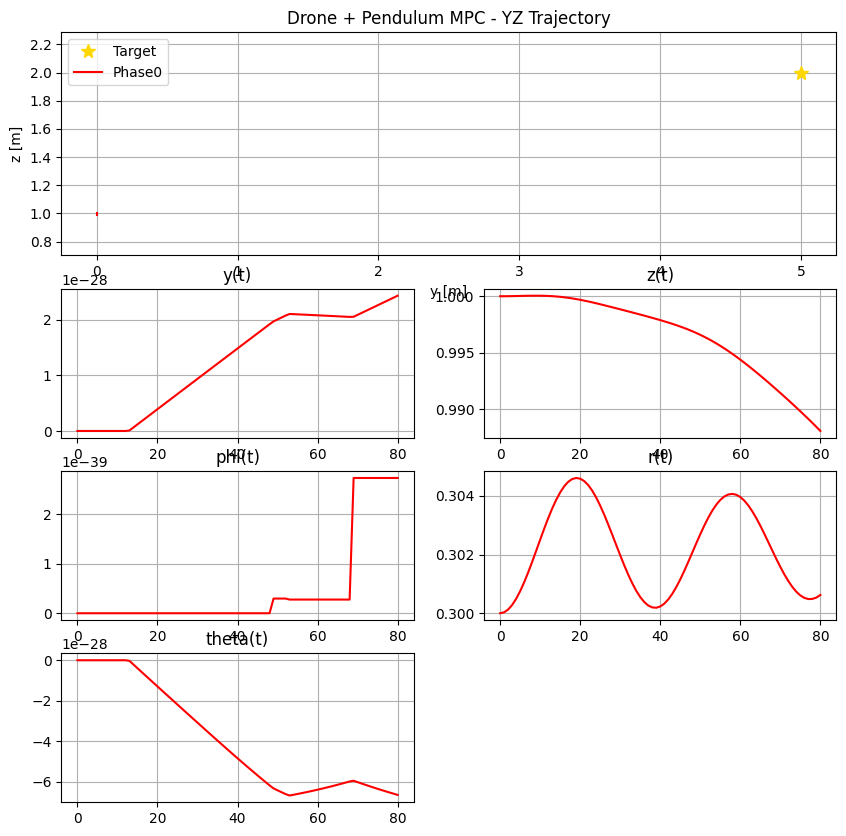

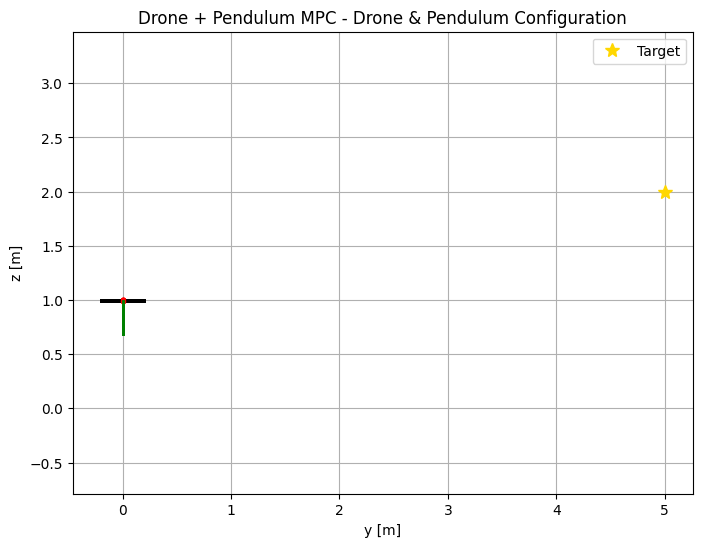

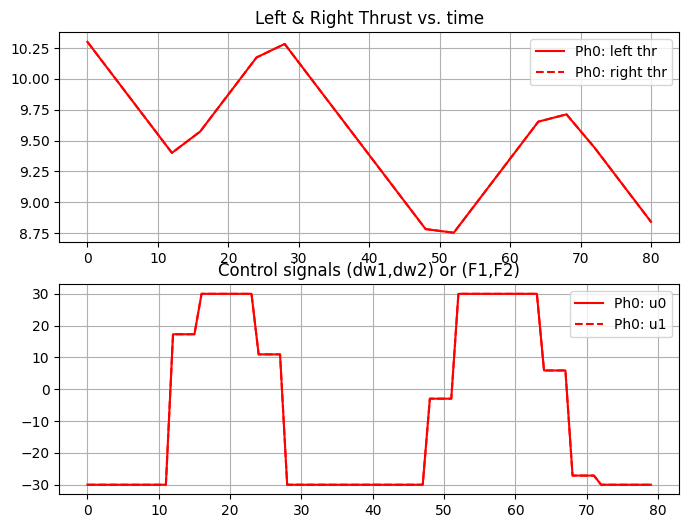

In [9]:
### 3) Lower Frequency ###
mpc_opts_3 = deepcopy(opts)
N = 150
mpc_opts_3.N = N
mpc_opts_3.step_sizes = [2*dt_inital_mpc]*N
mpc_opts_3.switch_stage = N+1
mpc_opts_3.integrator_type = "IRK"
mpc_opts_3.levenberg_marquardt = 8e-3
mpc_3 = DroneMPC(mpc_opts_3)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_3, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=2*control_step
)

plot_drone_mpc_solution(
    mpc=mpc_3, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_3
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

rm -f libacados_ocp_solver_drone_full_1742961166211.so
rm -f drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_0_fun.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_0_fun_jac_ut_xt.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_0_hess.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_fun.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_fun_jac_ut_xt.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_hess.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_e_fun.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_e_fun_jac_ut_xt.o drone_full_1742961166211_cost/drone_full_1742961166211_cost_y_e_hess.o acados_solver_drone_full_1742961166211.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

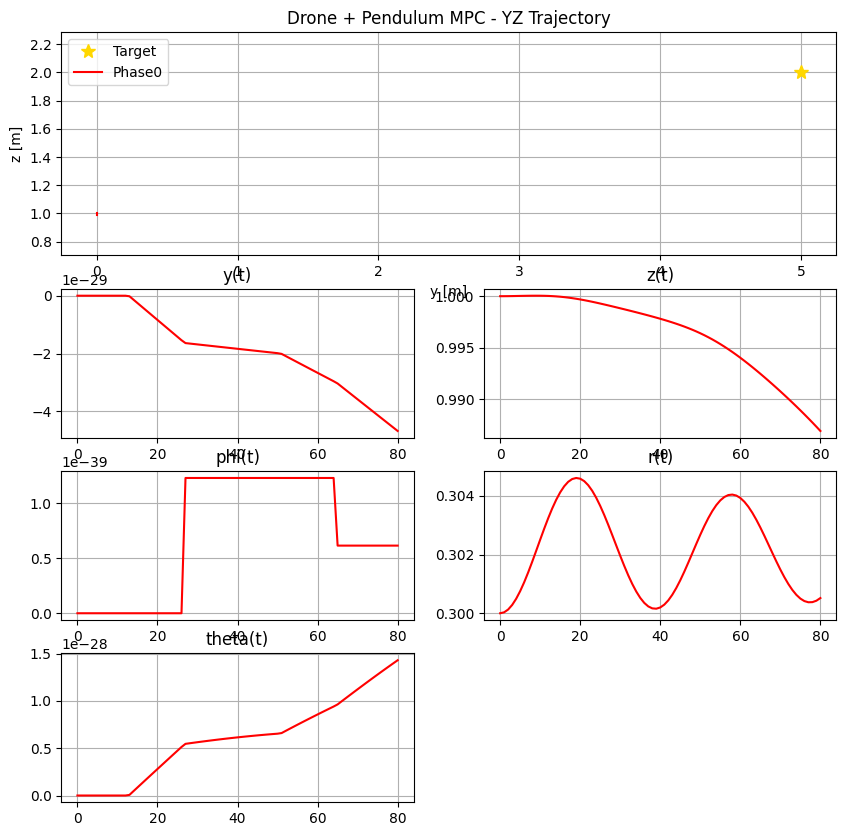

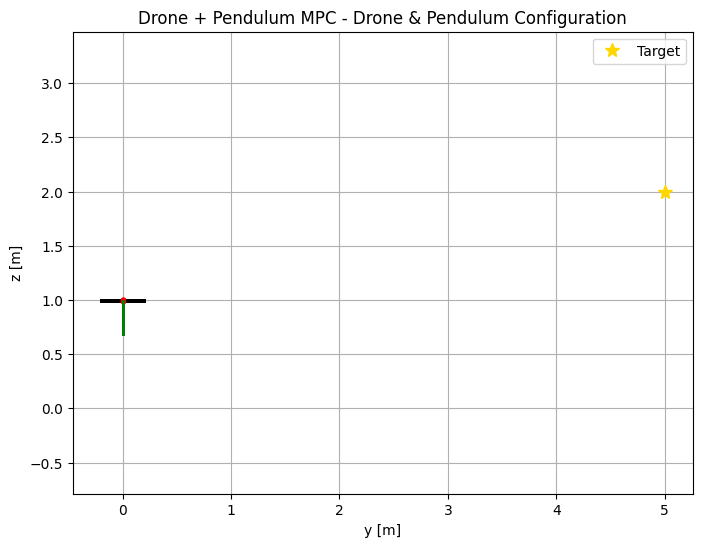

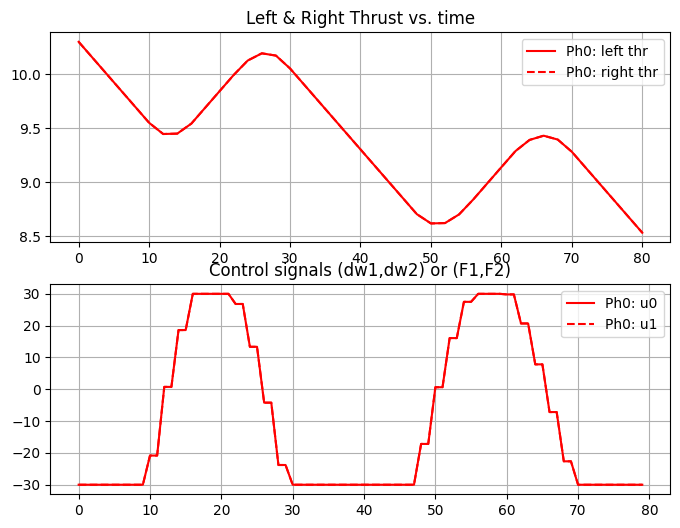

In [10]:
### 4) Myopic MPC ###
mpc_opts_4 = deepcopy(opts)
N = 100
mpc_opts_4.N = N
mpc_opts_4.step_sizes = [dt_inital_mpc]*N
mpc_opts_4.switch_stage = N+1
mpc_opts_4.integrator_type = "IRK"
mpc_opts_4.levenberg_marquardt = 8e-3
mpc_4 = DroneMPC(mpc_opts_4)


# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_4, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_4, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_4
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

rm -f libacados_ocp_solver_drone_ignorepend_1742961186887.so
rm -f drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_0_fun.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_0_fun_jac_ut_xt.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_0_hess.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_fun.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_fun_jac_ut_xt.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_hess.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_e_fun.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_e_fun_jac_ut_xt.o drone_ignorepend_1742961186887_cost/drone_ignorepend_1742961186887_cost_y_e_hess.o acados_solver_drone_ignorepend_1742961186887.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zu

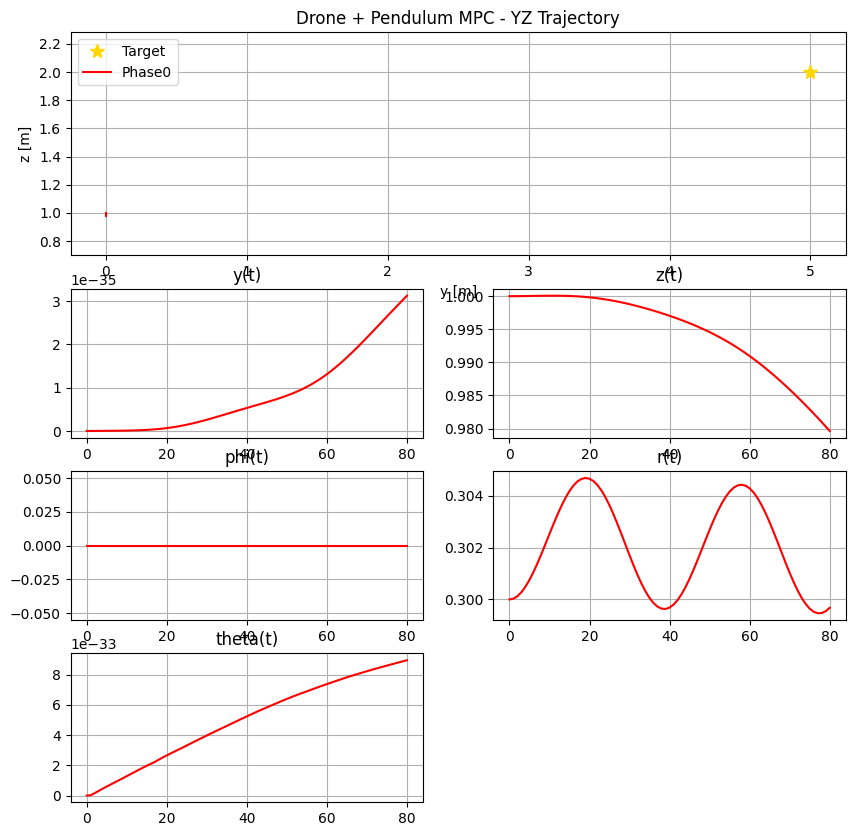

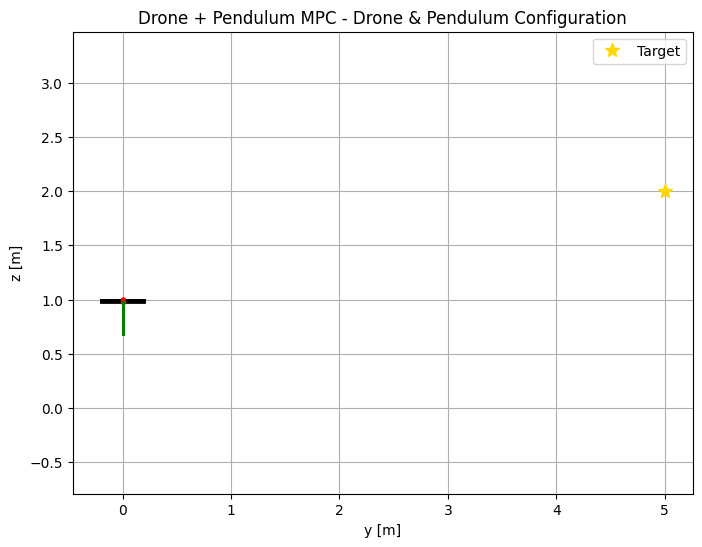

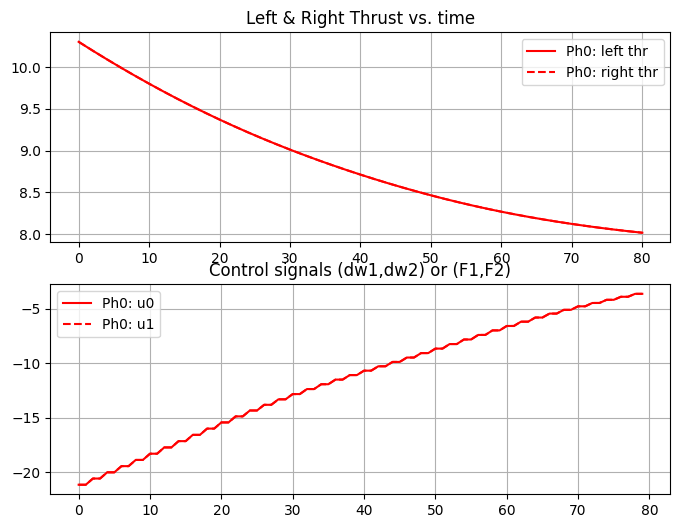

In [11]:
### 5)  Approximate model only ###
mpc_opts_5 = deepcopy(opts)
N = 300
mpc_opts_5.N = N
mpc_opts_5.step_sizes = [dt_inital_mpc]*N
mpc_opts_5.switch_stage = 0
mpc_opts_5.integrator_type = "IRK"
mpc_opts_5.levenberg_marquardt = 1e-3
mpc_5 = DroneMPC(mpc_opts_5)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_5, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_5, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_5
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

rm -f libacados_ocp_solver_drone_full_1742961192442.so
rm -f drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_0_fun.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_0_fun_jac_ut_xt.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_0_hess.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_fun.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_fun_jac_ut_xt.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_hess.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_e_fun.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_e_fun_jac_ut_xt.o drone_full_1742961192442_cost/drone_full_1742961192442_cost_y_e_hess.o acados_solver_drone_full_1742961192442.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

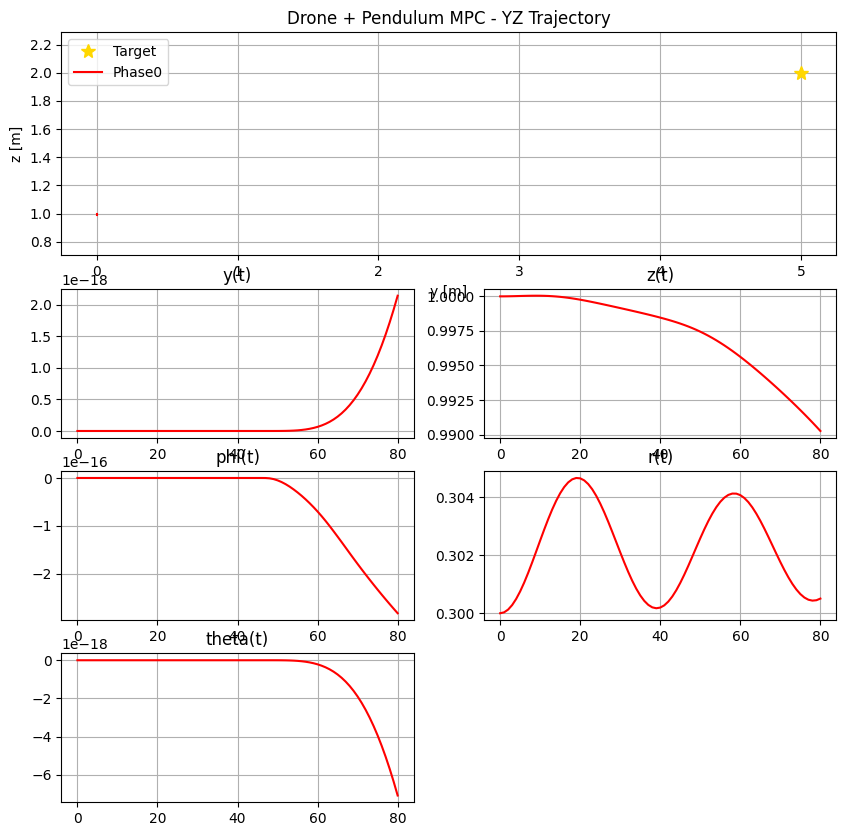

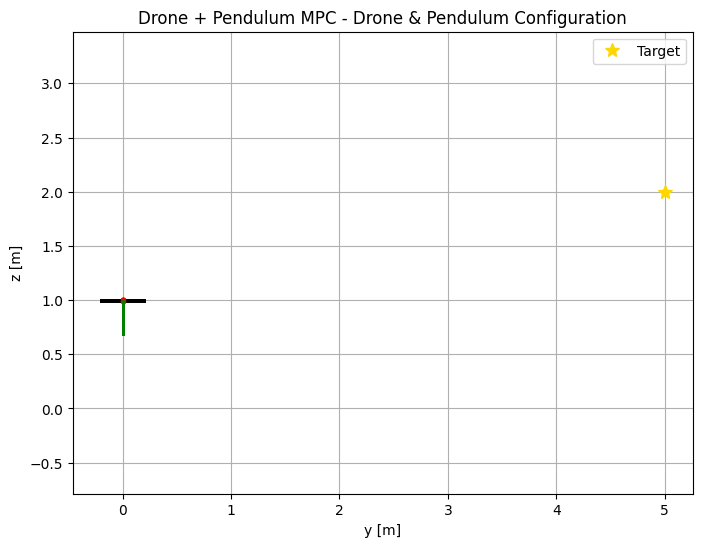

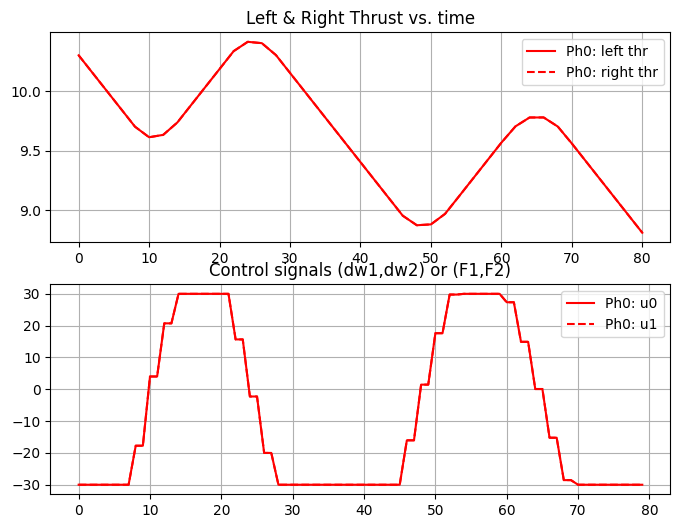

In [12]:
### 6) Exonential increase in stepsizes ###
from utils_drone import compute_exponential_step_sizes
mpc_opts_6 = deepcopy(opts)
N = 100
mpc_opts_6.N = N
mpc_opts_6.step_sizes = compute_exponential_step_sizes(
    dt_initial=dt_inital_mpc,
    T_total=dt_inital_mpc*300,
    N_steps=N,
    plot=False
)
mpc_opts_6.switch_stage = N+1
mpc_opts_6.integrator_type = "IRK"
mpc_opts_6.levenberg_marquardt = 8e-3 # smaller problem size, this levenberg marquardt term is also sufficient here
mpc_6 = DroneMPC(mpc_opts_6)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_6, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_6, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_6
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globaliza

acados_solver_multiphase_ocp_150_1_150_20250325_205335_502052.c: In function ‘multiphase_ocp_150_1_150_20250325_205335_502052_acados_create_with_discretization’:
acados_solver_multiphase_ocp_150_1_150_20250325_205335_502052.c:2833:25: warning: too many arguments for format [-Wformat-extra-args]
 2833 |         fprintf(stderr, "multiphase_ocp_150_1_150_20250325_205335_502052_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o drone_full_1742961215502_model/drone_full_1742961215502_impl_dae_fun.o drone_full_1742961215502_model/drone_full_1742961215502_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o drone_full_1742961215502_model/drone_full_1742961215502_impl_dae_fun_jac_x_xdot_z.o drone_full_17429612155

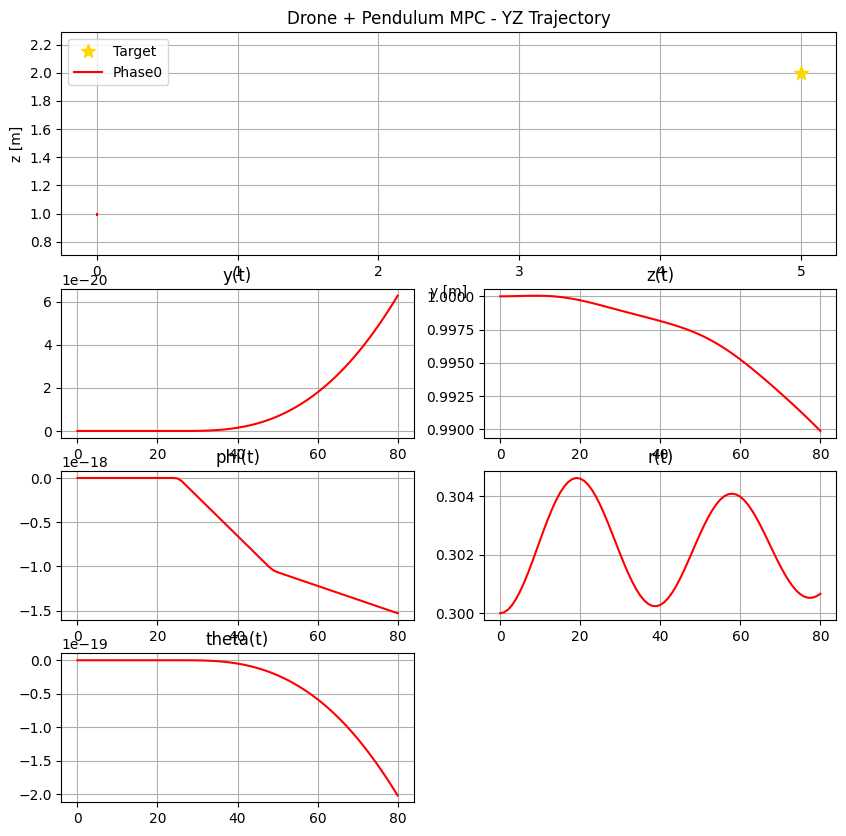

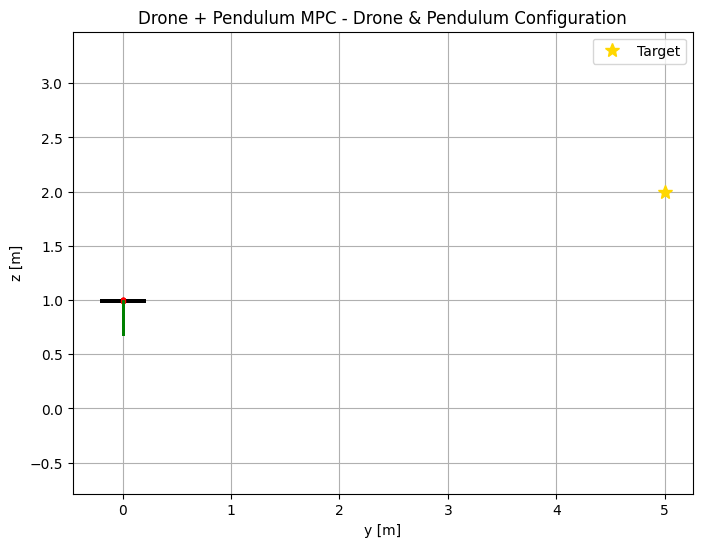

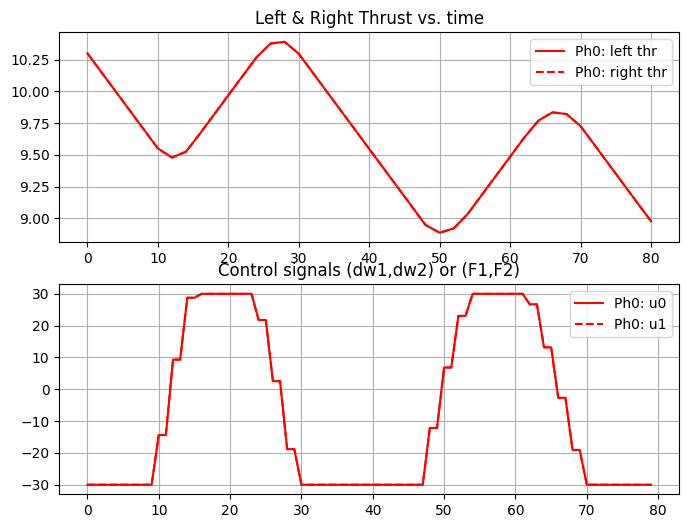

In [13]:
### 7) Only model switching ###
mpc_opts_7 = deepcopy(opts)
N = 300
mpc_opts_7.N = N
mpc_opts_7.step_sizes = [dt_inital_mpc]*N
mpc_opts_7.switch_stage = 150
mpc_opts_7.integrator_type = "IRK"
mpc_opts_7.levenberg_marquardt = 1e-3
mpc_7 = DroneMPC(mpc_opts_7)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_7, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_7, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_7
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

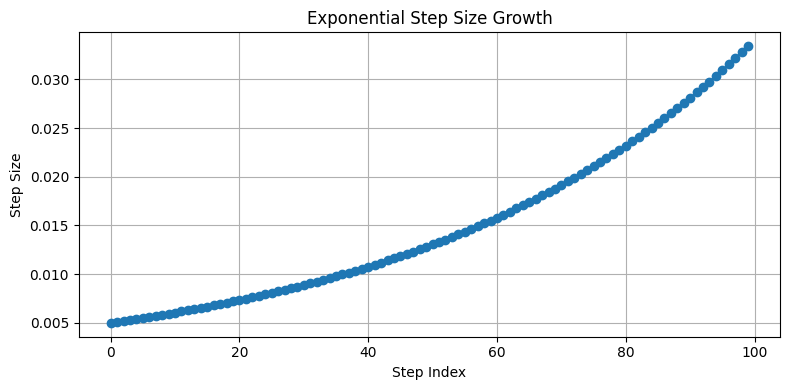

The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globaliza

acados_solver_multiphase_ocp_50_1_50_20250325_210353_072350.c: In function ‘multiphase_ocp_50_1_50_20250325_210353_072350_acados_create_with_discretization’:
acados_solver_multiphase_ocp_50_1_50_20250325_210353_072350.c:1833:25: warning: too many arguments for format [-Wformat-extra-args]
 1833 |         fprintf(stderr, "multiphase_ocp_50_1_50_20250325_210353_072350_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o drone_full_1742961833072_model/drone_full_1742961833072_impl_dae_fun.o drone_full_1742961833072_model/drone_full_1742961833072_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o drone_full_1742961833072_model/drone_full_1742961833072_impl_dae_fun_jac_x_xdot_z.o drone_full_17429618330

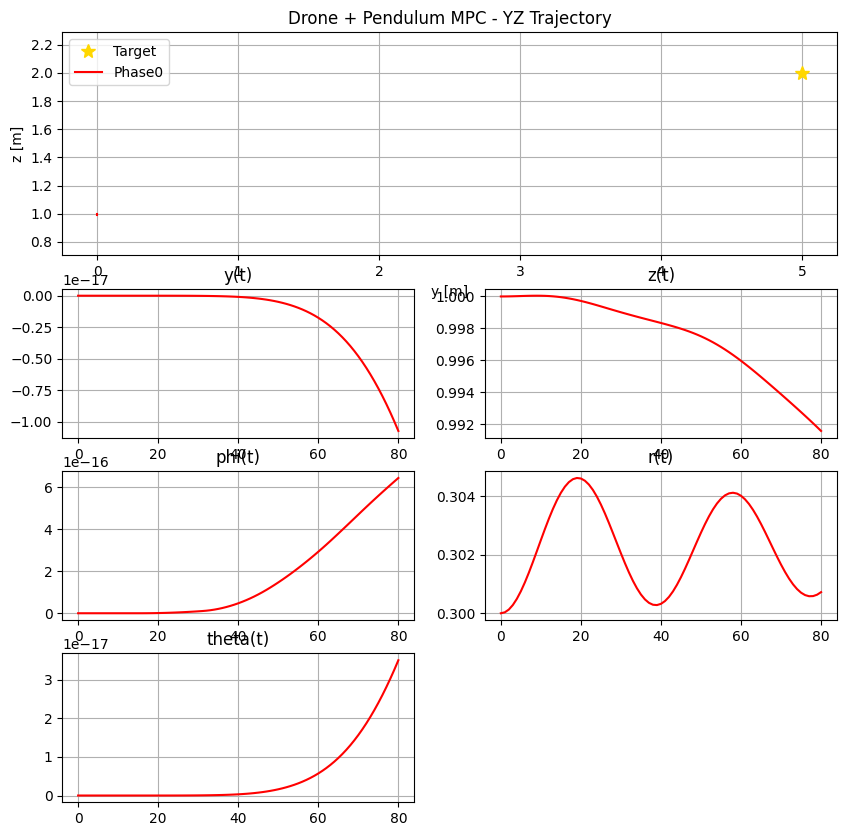

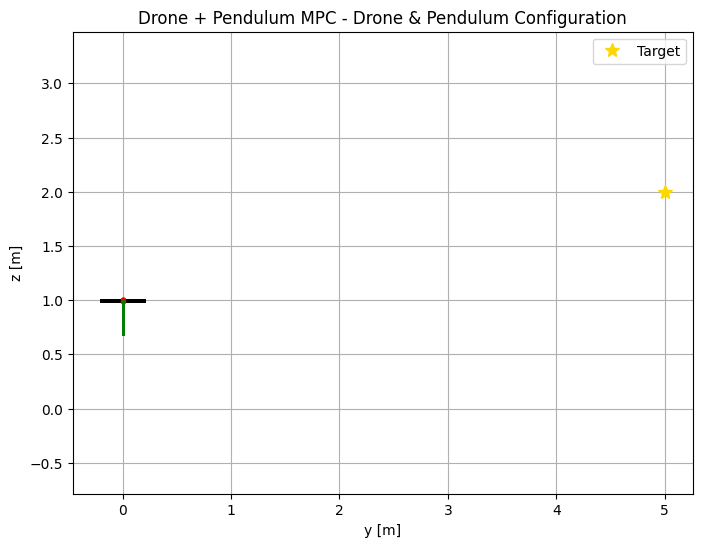

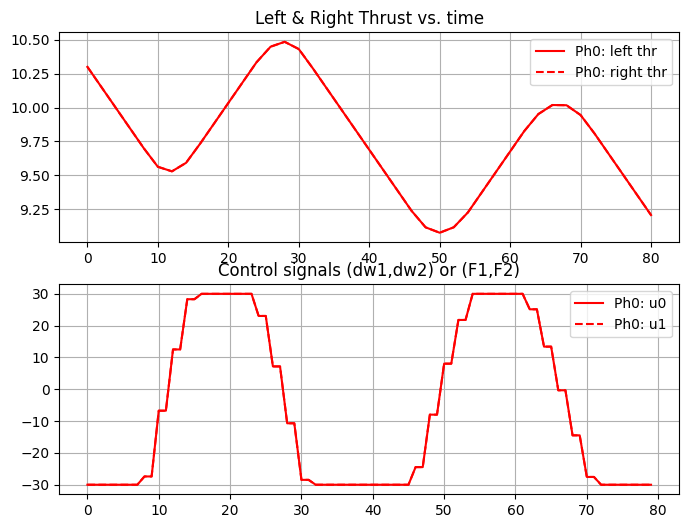

In [16]:
### 8) Ours: Model switching with exponential increase in stepsizes ###
from utils_drone import compute_exponential_step_sizes
mpc_opts_8 = deepcopy(opts)
N = 100
mpc_opts_8.N = N
mpc_opts_8.step_sizes = compute_exponential_step_sizes(
    dt_initial=dt_inital_mpc,
    T_total=dt_inital_mpc*300,
    N_steps=N,
    plot=True
)
mpc_opts_8.switch_stage = 50
mpc_opts_8.integrator_type = "IRK"
mpc_opts_8.levenberg_marquardt = 1e-3 
mpc_8 = DroneMPC(mpc_opts_8)

# simulate
x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop_drone(
    X0, 
    mpc_8, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=stage_cost_function,
    sigma_noise=0.0,  
    sim_solver=sim_solver, 
    control_step=control_step
)

plot_drone_mpc_solution(
    mpc=mpc_8, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_8
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

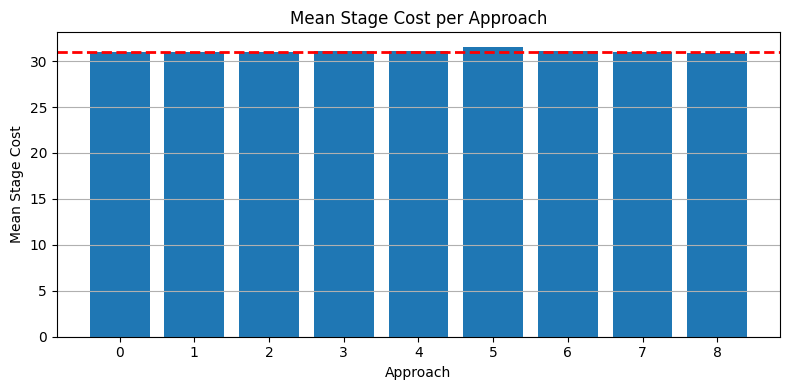

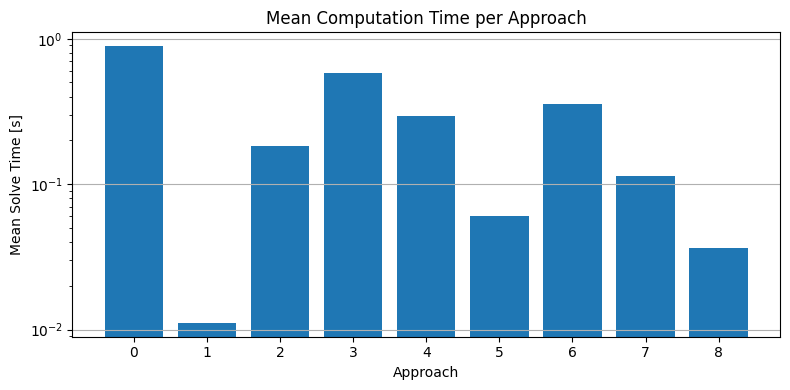

[31.008059378535513, 30.951217992142166, 31.008652027294147, 31.079528750543545, 31.052471585131023, 31.55400586638432, 31.063364323580213, 30.966647478724383, 30.867434700099956]
[0.888484275, 0.011106025, 0.18219495, 0.58073765, 0.29586215000000005, 0.060641999999999995, 0.3568347, 0.11392142499999999, 0.036274525]


In [15]:
import matplotlib.pyplot as plt

# Plot as bar diagrams the mean costs and mean computation times of the different approaches
# X-axis labels for the bars
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Plot 1: Mean Stage Costs
plt.figure(figsize=(8, 4))
plt.bar(labels, mean_costs)
plt.axhline(y=mean_costs[0], color='red', linestyle='--', linewidth=2, label='Baseline')
plt.xlabel("Approach")
plt.ylabel("Mean Stage Cost")
plt.title("Mean Stage Cost per Approach")
plt.xticks(labels)
#plt.ylim(4500, 5500)
#plt.yscale('log') 
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Mean Computation Time
plt.figure(figsize=(8, 4))
plt.bar(labels, mean_solve_times)
plt.xlabel("Approach")
plt.ylabel("Mean Solve Time [s]")
plt.title("Mean Computation Time per Approach")
plt.xticks(labels)
plt.grid(True, axis='y')
plt.yscale('log') 
plt.tight_layout()
plt.show()

print(mean_costs)
print(mean_solve_times)